<a href="https://colab.research.google.com/github/sethnlewis/Kenai_Dipnetting/blob/main/Salmon%20Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install prophet

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

logging.getLogger("cmdstanpy").disabled = True

In [21]:
# Import 2025 counts
google_sheet_url = 'https://docs.google.com/spreadsheets/d/1k0cNGbc7z-qemRxByvpwDbPzMEgzIOyQeitW7UicALA/edit?usp=sharing'
sheet_id = '1k0cNGbc7z-qemRxByvpwDbPzMEgzIOyQeitW7UicALA'
csv_export_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv'
df_2025 = pd.read_csv(csv_export_url)
df_2025['count_date'] = pd.to_datetime(df_2025['count_date'])
df_2025['fish_count'] = df_2025['fish_count'].str.replace(',', '').astype('int')
df_2025.rename({'count_date': 'ds', 'fish_count': 'y'}, inplace=True, axis=1)
df_2025 = df_2025[(df_2025["ds"].dt.month == 7) | (df_2025["ds"].dt.month == 8)].copy()

In [22]:
start_year = 1979
start_month = 3
start_day = 1
end_year = 2024

# Import historical counts
google_sheet_url = 'https://docs.google.com/spreadsheets/d/1taGhqLgomooSpDLYDfA5AwMsz8AHfitHIcnzjanNxhM/edit?usp=sharing'
sheet_id = '1taGhqLgomooSpDLYDfA5AwMsz8AHfitHIcnzjanNxhM'
csv_export_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv'
df_historical = pd.read_csv(csv_export_url)
df_historical['count_date'] = pd.to_datetime(df_historical['count_date'])
df_historical.rename({'count_date': 'ds', 'fish_count': 'y'}, inplace=True, axis=1)
df_historical = df_historical[(df_historical["ds"].dt.month == 7) | (df_historical["ds"].dt.month == 8)].copy()
df_historical['ds'] = pd.to_datetime(df_historical['ds'])

all_dates = pd.date_range(start='{}-01-01'.format(start_year), end='{}-12-31'.format(end_year), freq='D')

# Add a row for every day between start_date and end_date
modeling_months = list(range(start_month, 9))
extra_months = all_dates[all_dates.month.isin(modeling_months)]


dates_to_add = extra_months[~extra_months.isin(df_historical['ds'])]
new_rows = pd.DataFrame({'ds': dates_to_add, 'y': 0})
df_historical = pd.concat([df_historical, new_rows], ignore_index=True)
df_historical = df_historical.sort_values(by='ds').reset_index(drop=True)
df_all = pd.concat([df_historical, df_2025], ignore_index=True)

In [23]:
# ASSUMES NO DATA AFTER 8/31
datadays_per_year = (datetime.strptime('2025-08-31', '%Y-%m-%d') - datetime.strptime('2025-{}-{}'.format(start_month, start_day), '%Y-%m-%d')).days + 1
days_since_start = list(range(1, datadays_per_year + 1))

multivariate = pd.DataFrame({'ds': days_since_start})
historical_years = [int(x) for x in df_historical['ds'].dt.year.unique()]
for year in historical_years:
  multivariate[str(year)] = df_historical[df_historical['ds'].dt.year == year].y.values
# future_df = pd.DataFrame({'ds': pd.date_range(start='2025-07-01', end='2025-08-31', freq='D')})
multivariate

,ds,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,180,0,253,0,0,0,0,0,0,0,...,0,0,0,9351,0,0,0,0,25826,0
180,181,0,227,0,0,0,0,0,0,0,...,0,0,0,1436,0,0,0,0,12864,0
181,182,0,152,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12875,0
182,183,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
def fit_and_forecast(start_year, end_year, known_2025=None, interval_width=0.9): # Function to fit and forecast 2025 given known 2025 values
  records = []
  df = multivariate.copy()

  for year in range(start_year, end_year+1):
      for day in range(df.shape[0]):
          records.append({
              'ds': pd.Timestamp('{}-{}-{}'.format(year, start_month, start_day)) + pd.Timedelta(days=day),
              'y': df.loc[day, str(year)]
              })
  df_long = pd.DataFrame(records)

  # Combine historical + known 2025 for training
  train_df = df_long.copy()
  if known_2025 is not None and not known_2025.empty:
      train_df = pd.concat([train_df, known_2025], ignore_index=True)

  # Fit Prophet
  m = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False, interval_width=interval_width)
  m.fit(train_df)

  # Future dates to predict: all 40 days of 2025
  future_dates = pd.date_range(start='2025-{}-{}'.format(start_month, start_day), periods=datadays_per_year, freq='D')
  future = pd.DataFrame({'ds': future_dates})

  # Predict
  forecast = m.predict(future)
  return m, forecast
  # return None, train_df

In [25]:

# Prepare historical data long-format as before


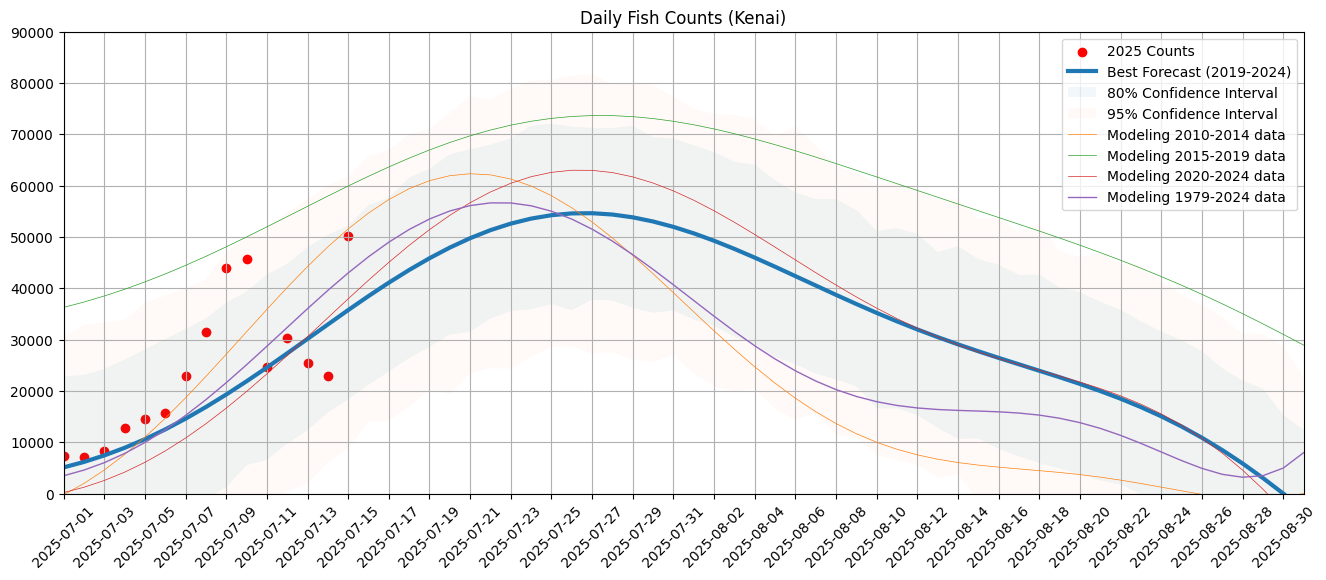

In [26]:
plt.figure(figsize=(16,6))

known_2025_df = df_2025.loc[df_2025['y']>0].copy()
model_updated, forecast_updated = fit_and_forecast(2015, 2024, known_2025_df, interval_width=0.8)

# 2025 data
plt.scatter(known_2025_df['ds'], known_2025_df['y'], color='red', label='2025 Counts')
plt.plot(forecast_updated['ds'], forecast_updated['yhat'], label='Best Forecast (2019-2024)', alpha=1, linewidth=3)

# Intervals
plt.fill_between(forecast_updated['ds'], forecast_updated['yhat_lower'], forecast_updated['yhat_upper'], alpha=0.06, label='80% Confidence Interval')
model_updated, forecast_updated = fit_and_forecast(2015, 2024, known_2025_df, interval_width=0.95)
plt.fill_between(forecast_updated['ds'], forecast_updated['yhat_lower'], forecast_updated['yhat_upper'], alpha=0.03, label='95% Confidence Interval')


# Year Groupings
plot_first_year = 2010
plot_last_year = 2024
plot_grouping_years = 5
all_max = []
for y in range(plot_first_year, plot_last_year+1, plot_grouping_years):
  end_year = min([y+plot_grouping_years-1, 2024])
  model, forecast = fit_and_forecast(y, end_year, None)
  label = 'Modeling {}-{} data'.format(y, end_year) if y != end_year else 'Modeling {} data'.format(y)
  plt.plot(forecast['ds'], forecast['yhat'], label=label, alpha=1, linewidth=0.5)


# 1979 - 2024
_, forecast = fit_and_forecast(1979, 2024, known_2025_df)
plt.plot(forecast['ds'], forecast['yhat'], label='Modeling 1979-2024 data', alpha=1, linewidth=1)


plt.title("Daily Fish Counts (Kenai)")
plt.grid(True)
plt.legend()
plt.xticks(forecast['ds'][::2], rotation=45)
plt.xlim(datetime(2025, 7, 1), datetime(2025, 8, 31))
plt.ylim([0, max(known_2025_df['y'].max() + 10000, 90000)])
plt.show()


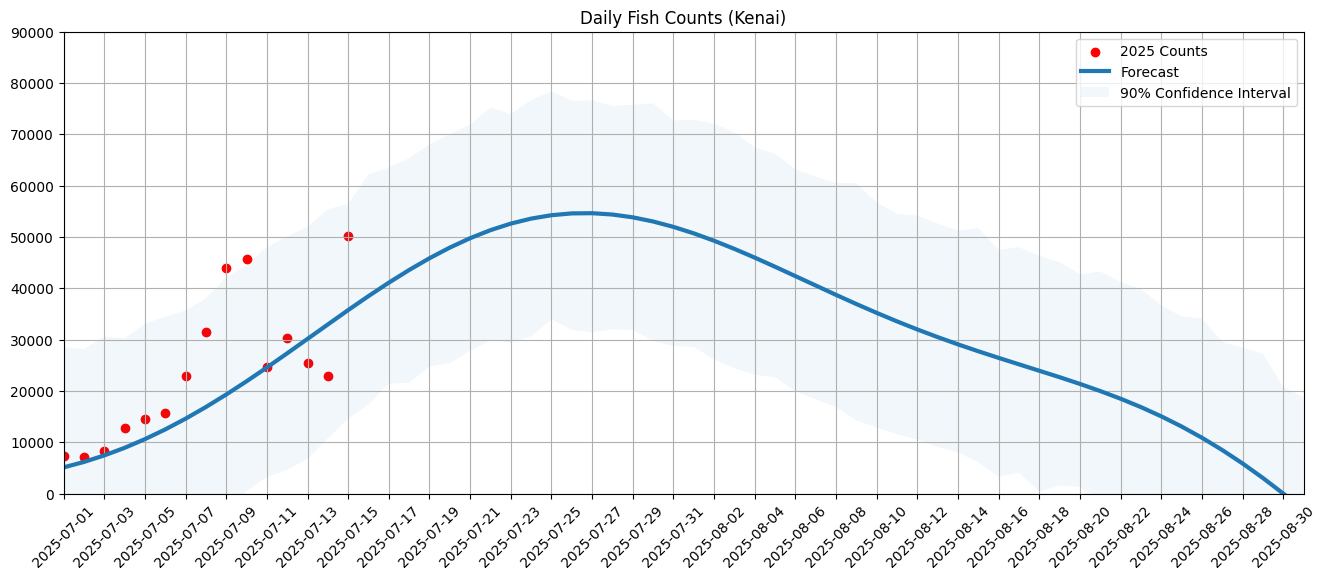

In [27]:
# Simple

plt.figure(figsize=(16,6))

known_2025_df = df_2025.loc[df_2025['y']>0].copy()
model_updated, forecast_updated = fit_and_forecast(2015, 2024, known_2025_df)

# 2025 data
plt.scatter(known_2025_df['ds'], known_2025_df['y'], color='red', label='2025 Counts')
plt.plot(forecast_updated['ds'], forecast_updated['yhat'], label='Forecast', linewidth=3)

# Intervals
plt.fill_between(forecast_updated['ds'], forecast_updated['yhat_lower'], forecast_updated['yhat_upper'], alpha=0.06, label='90% Confidence Interval')


# Year Groupings
plt.title("Daily Fish Counts (Kenai)")
plt.grid(True)
plt.legend()
plt.xticks(forecast['ds'][::2], rotation=45)
plt.xlim(datetime(2025, 7, 1), datetime(2025, 8, 31))
plt.ylim([0, max(known_2025_df['y'].max() + 10000, 90000)])
plt.show()


In [28]:
# Inspect how the peak date has changed over time
all_max = []
for y in range(1979, 2025):
  # Prepare historical data long-format as before
  _, forecast = fit_and_forecast(y, y)
  date = forecast.loc[forecast['yhat'].idxmax()]['ds'].replace(year=y)
  days = (date-datetime(y, start_month, start_day)).days
  max_val = forecast.loc[forecast['yhat'].idxmax()]['yhat']
  all_max.append((date, days, max_val))


max_by_year = pd.DataFrame(all_max)
max_by_year.rename(columns={0: 'Peak_Date', 1: 'Peak_Day', 2: 'Peak_Count'}, inplace=True)

X = max_by_year['Peak_Date'].dt.year.values.reshape(-1, 1)
y = max_by_year['Peak_Day'].values

In [29]:
# Revised

# Inspect how the peak date has changed over time
all_max = []
for y in range(1979, 2025):
  # Prepare historical data long-format as before
  _, forecast = fit_and_forecast(y, y)
  date = forecast.loc[forecast['yhat'].idxmax()]['ds'].replace(year=y)
  days = (date-datetime(y, 7, 1)).days
  max_val = forecast.loc[forecast['yhat'].idxmax()]['yhat']
  all_max.append((date, days, max_val))

max_by_year = pd.DataFrame(all_max)
max_by_year.rename(columns={0: 'Peak_Date', 1: 'Peak_Day', 2: 'Peak_Count'}, inplace=True)

X = max_by_year['Peak_Date'].dt.year.values.reshape(-1, 1)
y = max_by_year['Peak_Day'].values

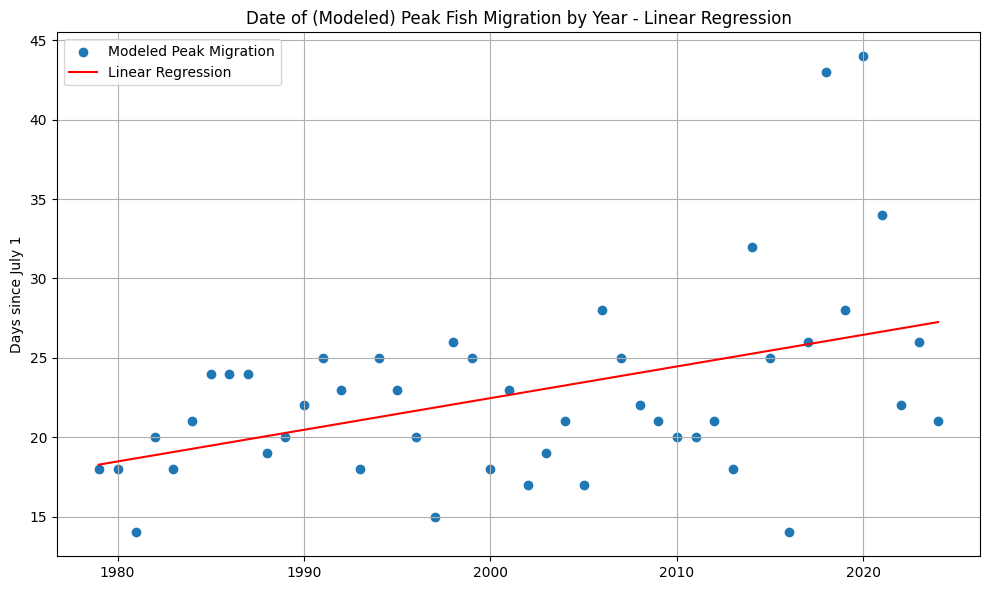

In [30]:
model = LinearRegression()
model.fit(X, y)

# Predict
x_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_fit = model.predict(x_fit)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, label="Modeled Peak Migration")
plt.plot(x_fit, y_fit, color="red", label="Linear Regression")
plt.title("Date of (Modeled) Peak Fish Migration by Year - Linear Regression")
plt.ylabel("Days since July 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

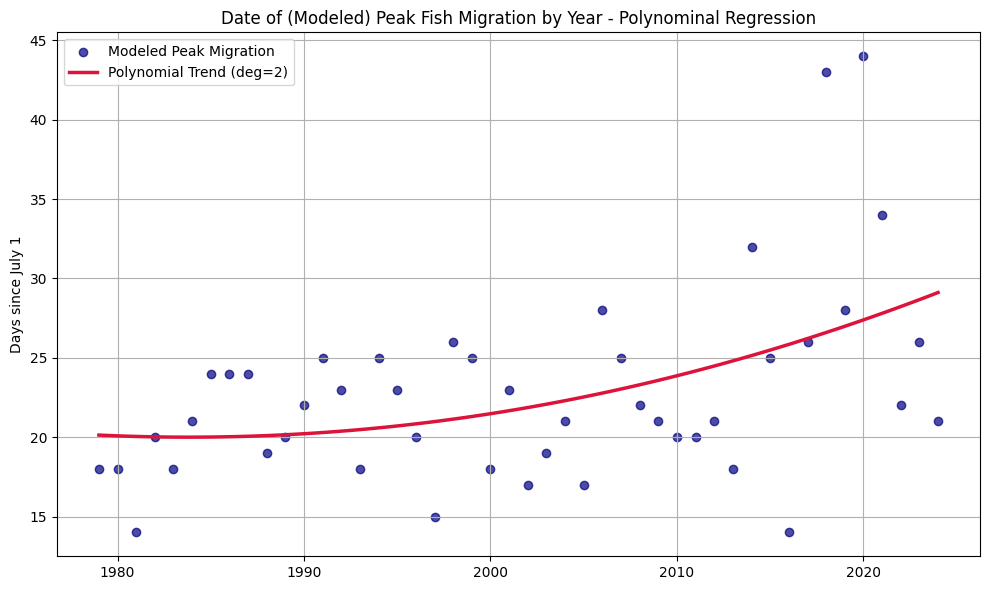

In [31]:
# 2nd Degree Polynomial Regression Model
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)

# Predict
x_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_fit = model.predict(x_fit)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='navy', label='Modeled Peak Migration', alpha=0.7)
plt.plot(x_fit, y_fit, color='crimson', linewidth=2.5, label=f'Polynomial Trend (deg={degree})')
plt.title("Date of (Modeled) Peak Fish Migration by Year - Polynominal Regression")
plt.ylabel("Days since July 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


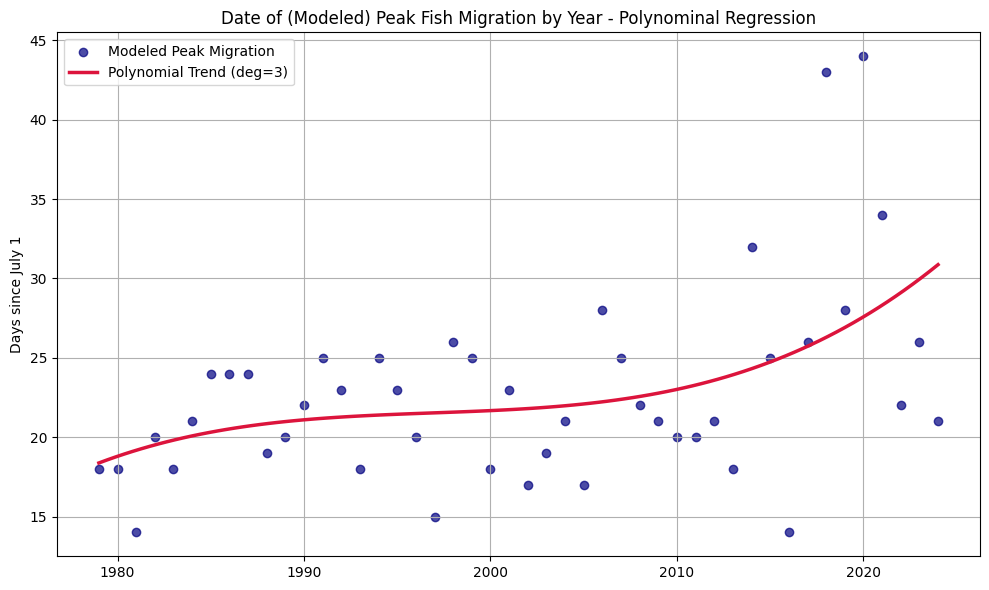

In [32]:
# 3rd Degree Polynomial Regression Model
degree = 3
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)

# Predict
x_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_fit = model.predict(x_fit)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='navy', label='Modeled Peak Migration', alpha=0.7)
plt.plot(x_fit, y_fit, color='crimson', linewidth=2.5, label=f'Polynomial Trend (deg={degree})')
plt.title("Date of (Modeled) Peak Fish Migration by Year - Polynominal Regression")
plt.ylabel("Days since July 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


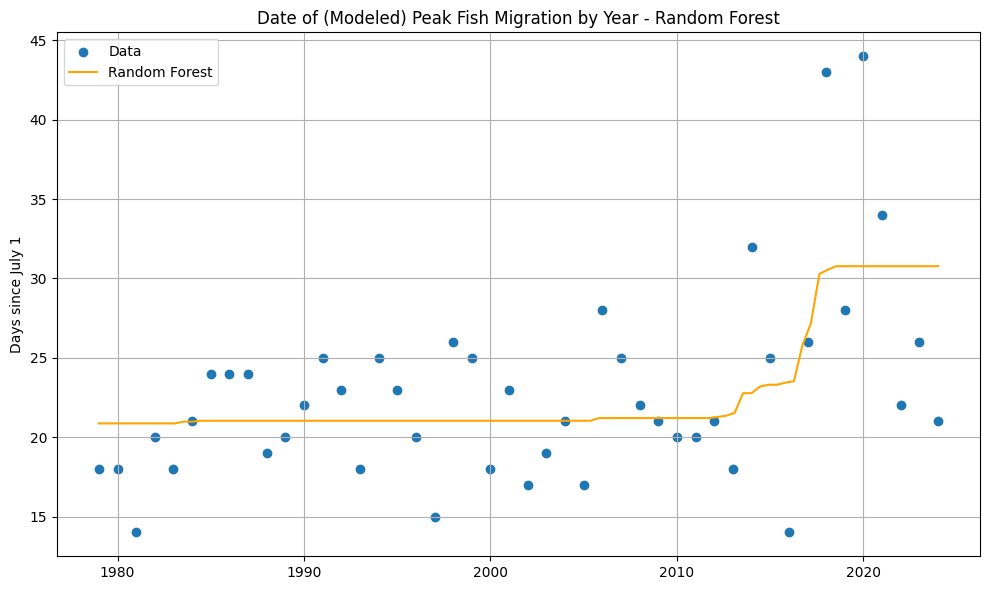

In [33]:
forest = RandomForestRegressor(random_state=0, max_depth=1)
forest.fit(X, y)

y_fit = forest.predict(x_fit)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, label="Data")
plt.plot(x_fit, y_fit, color="orange", label="Random Forest")
plt.title("Date of (Modeled) Peak Fish Migration by Year - Random Forest")
plt.ylabel("Days since July 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

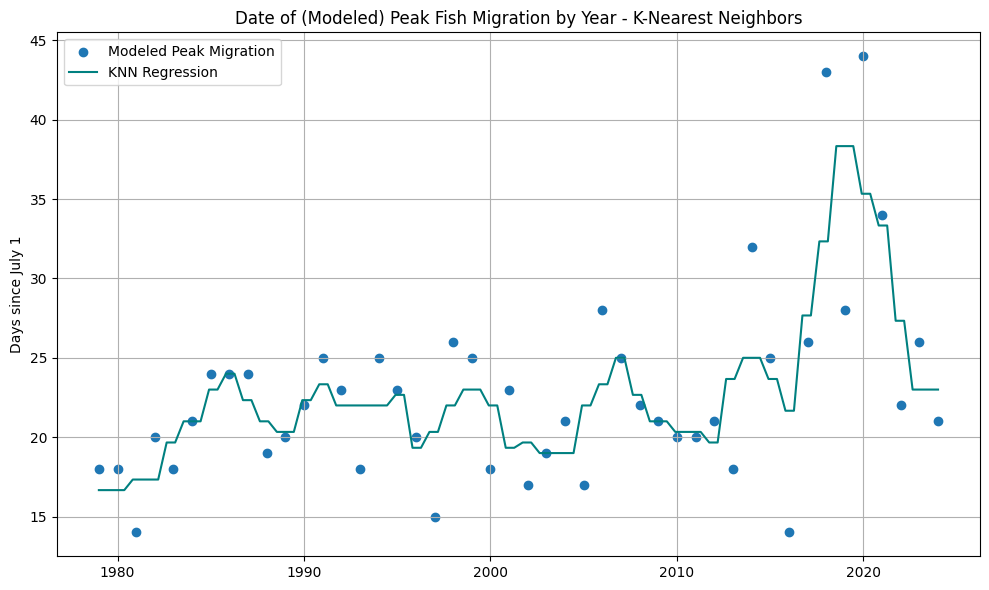

In [34]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X, y)

y_fit = knn.predict(x_fit)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, label="Modeled Peak Migration")
plt.plot(x_fit, y_fit, color="teal", label="KNN Regression")
plt.title("Date of (Modeled) Peak Fish Migration by Year - K-Nearest Neighbors")
plt.ylabel("Days since July 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


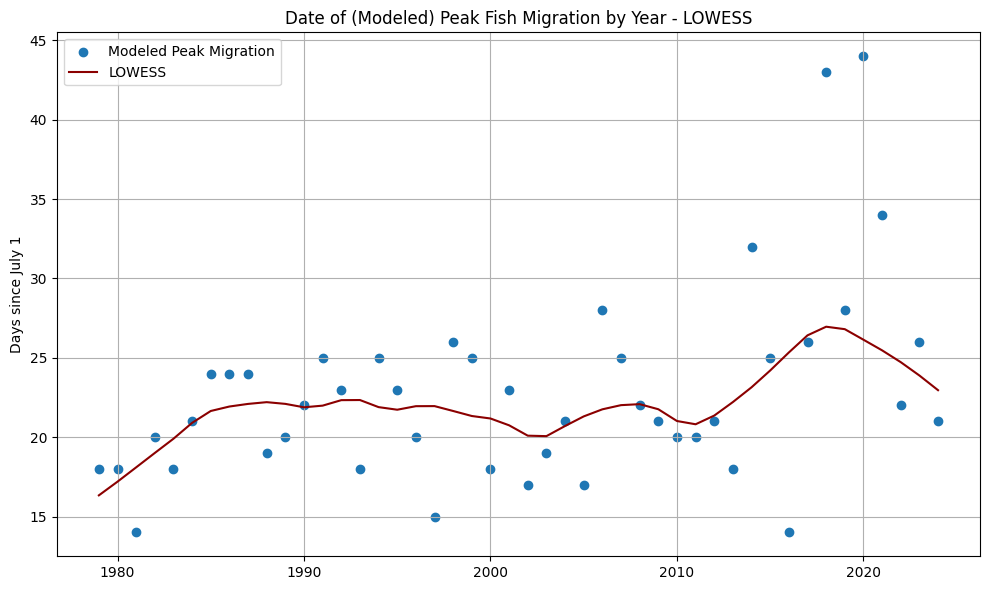

In [35]:
lowess = sm.nonparametric.lowess
smoothed = lowess(y, X.flatten(), frac=0.25)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, label="Modeled Peak Migration")
plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkred", label="LOWESS")
plt.title("Date of (Modeled) Peak Fish Migration by Year - LOWESS")
plt.ylabel("Days since July 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


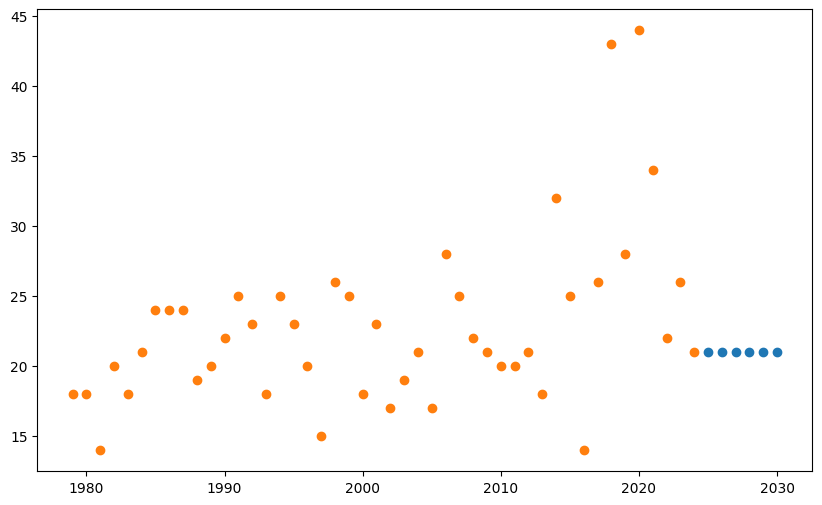

In [36]:
# XGBoost

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np


# Define model
model = xgb.XGBRegressor()

# Train model
model.fit(X, y)

# Predict
x_pred = [2025, 2026, 2027, 2028, 2029, 2030]
y_pred = model.predict(x_pred)

plt.figure(figsize=(10, 6))
plt.scatter(x_pred, y_pred, label="Modeled Peak Migration")
plt.scatter(X, y, label="Modeled Peak Migration")



/tmp/ipython-input-37-2662102281.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14,4))


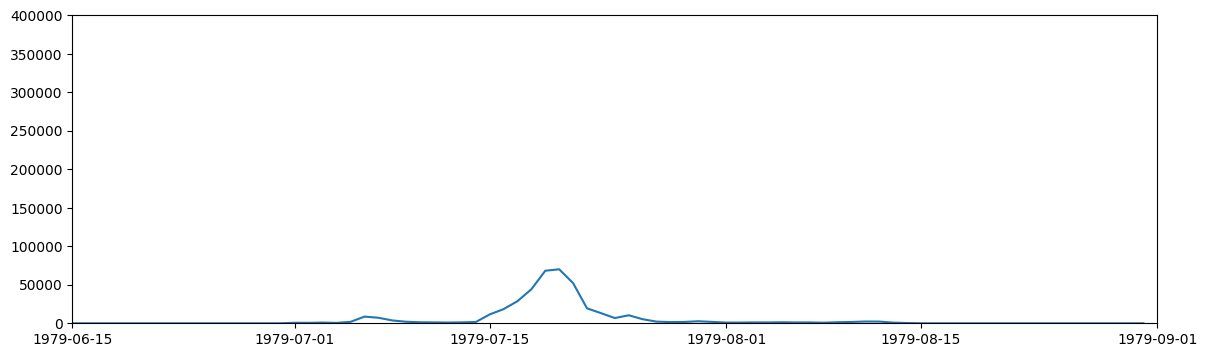

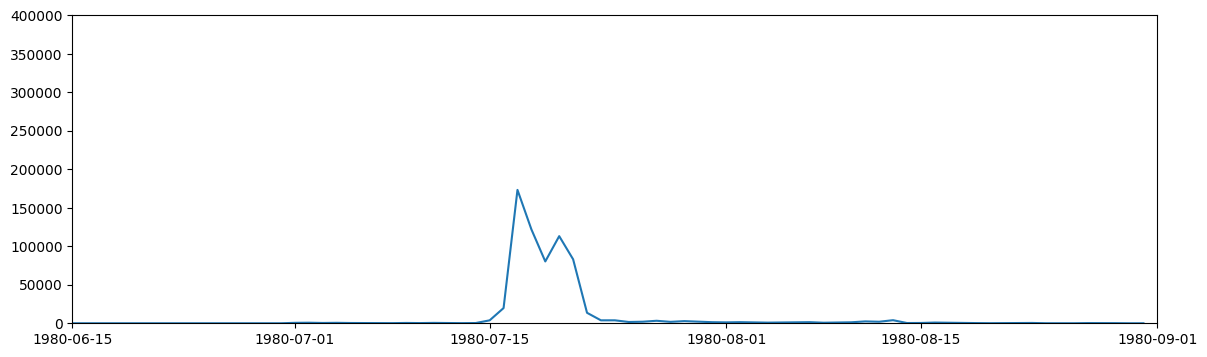

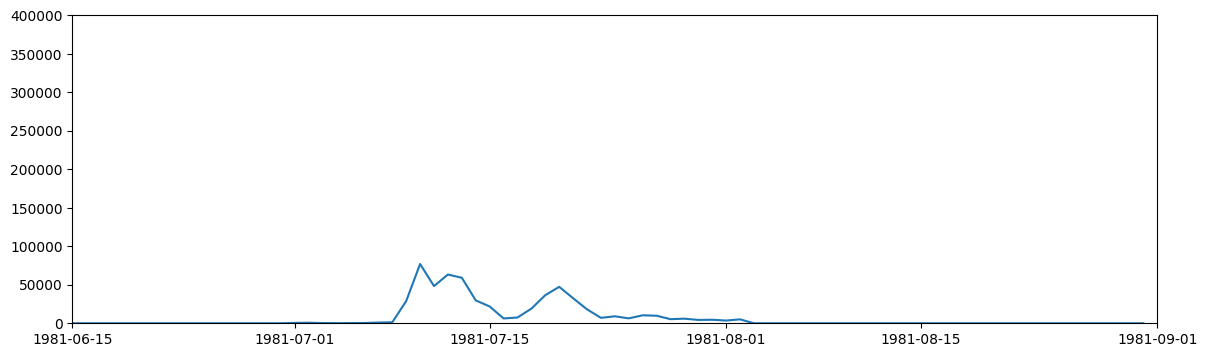

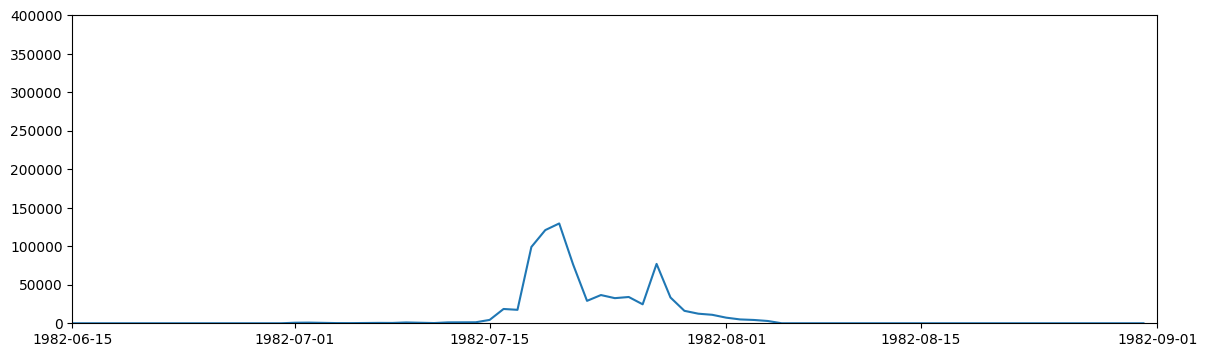

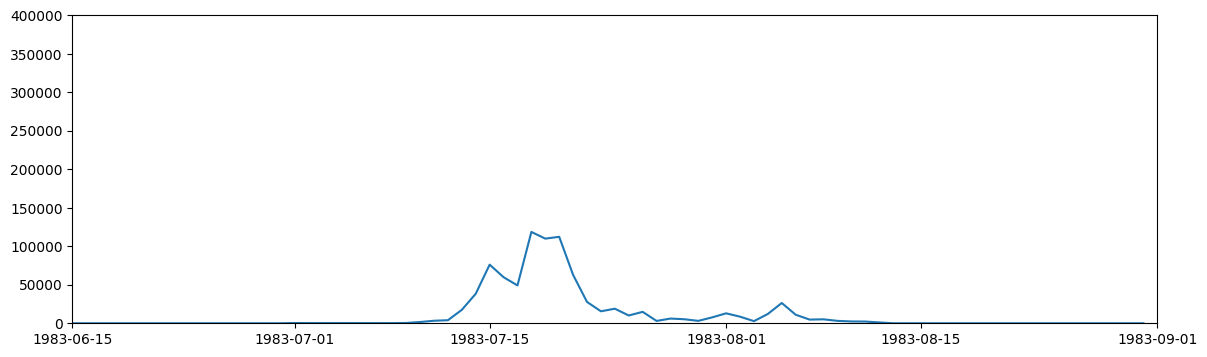

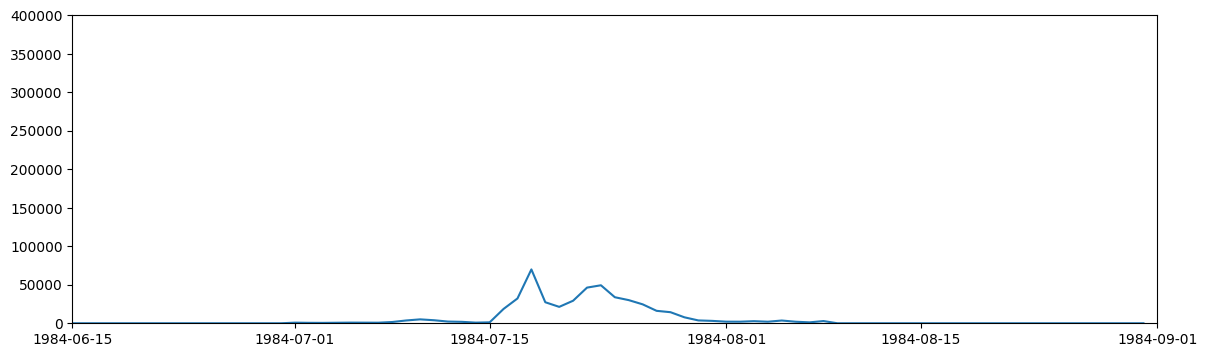

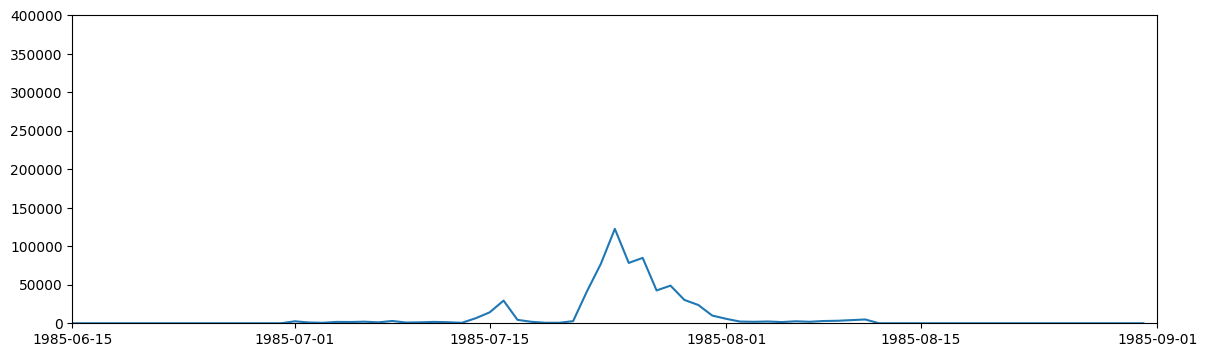

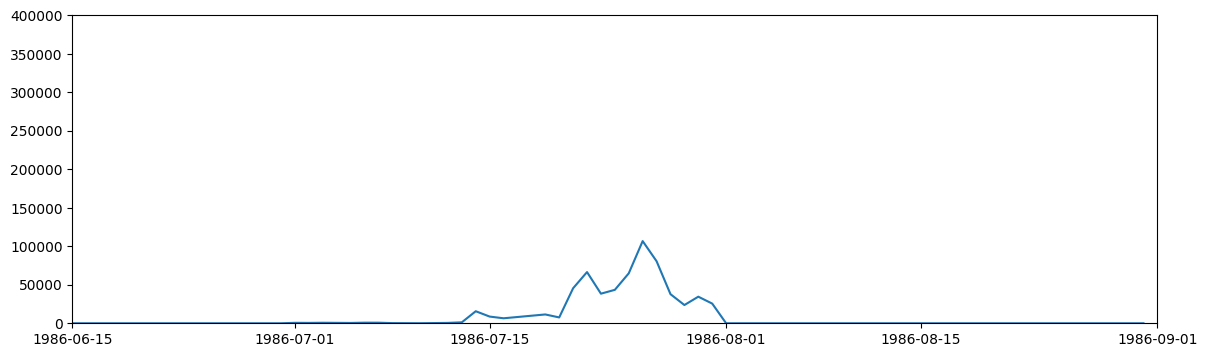

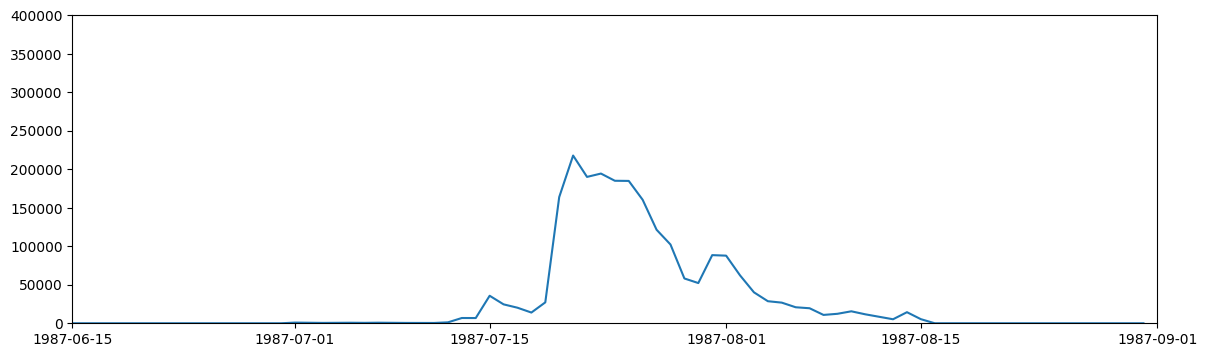

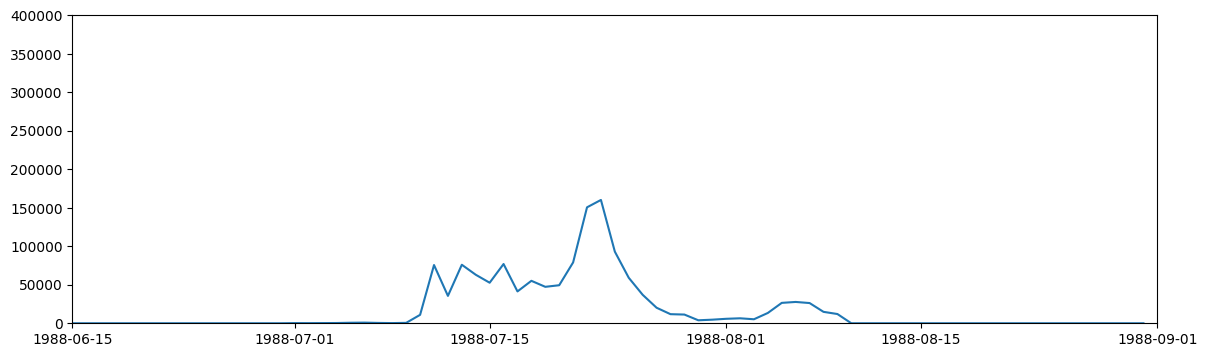

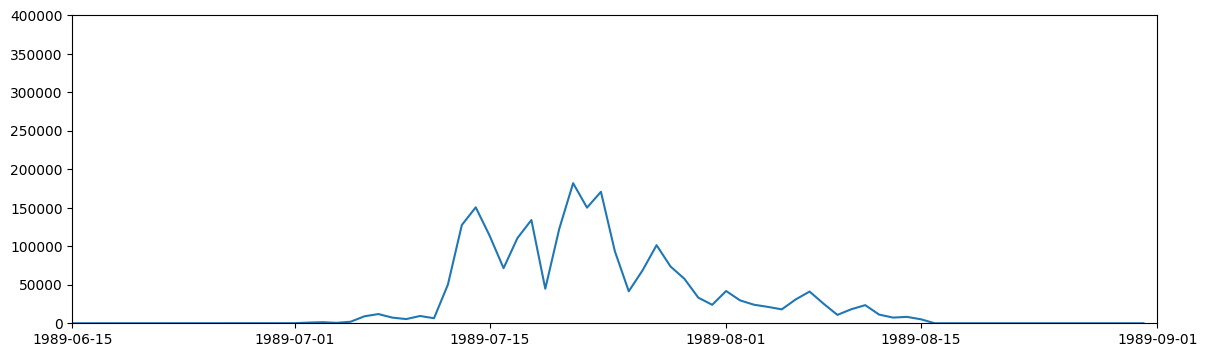

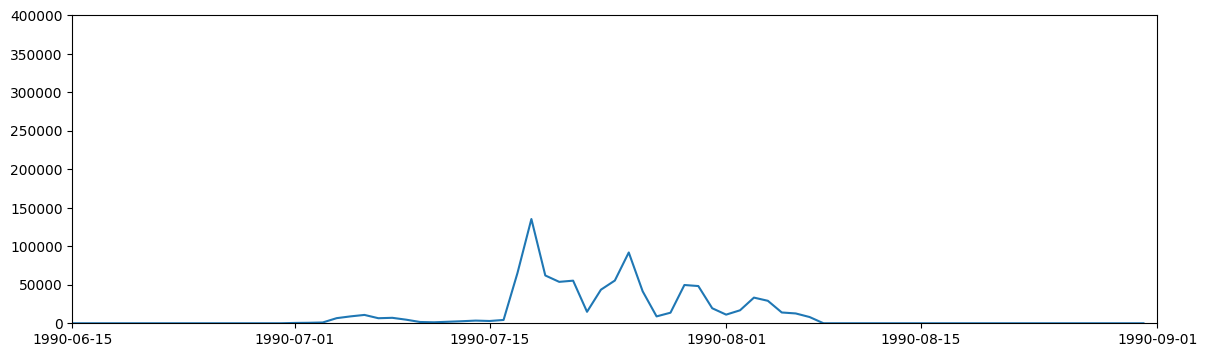

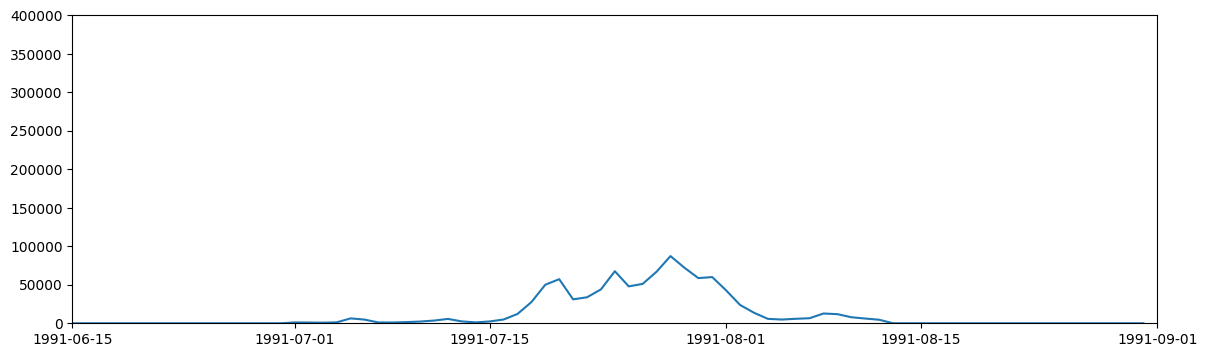

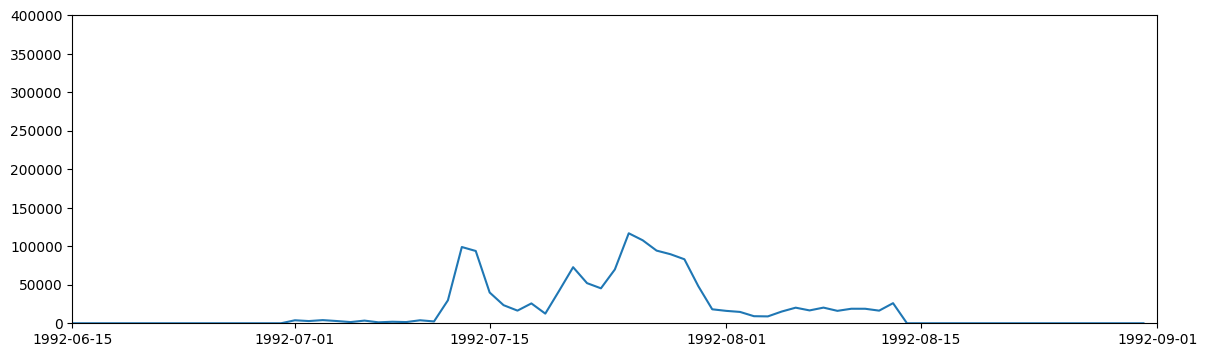

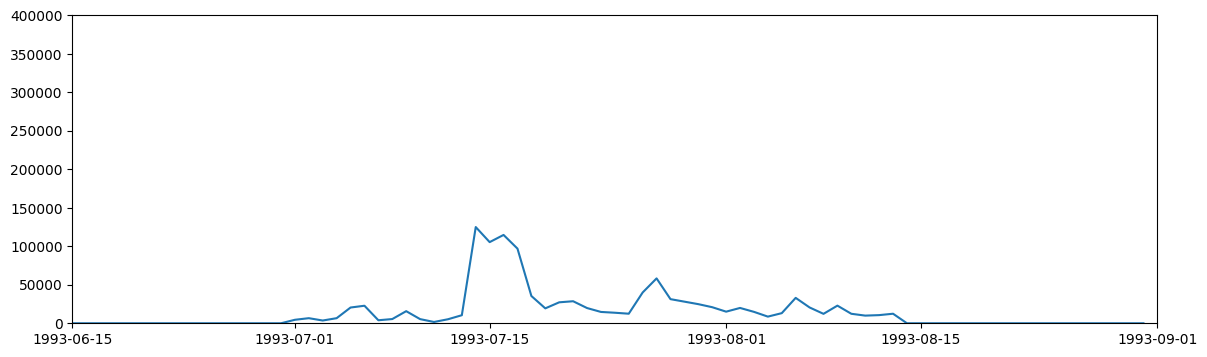

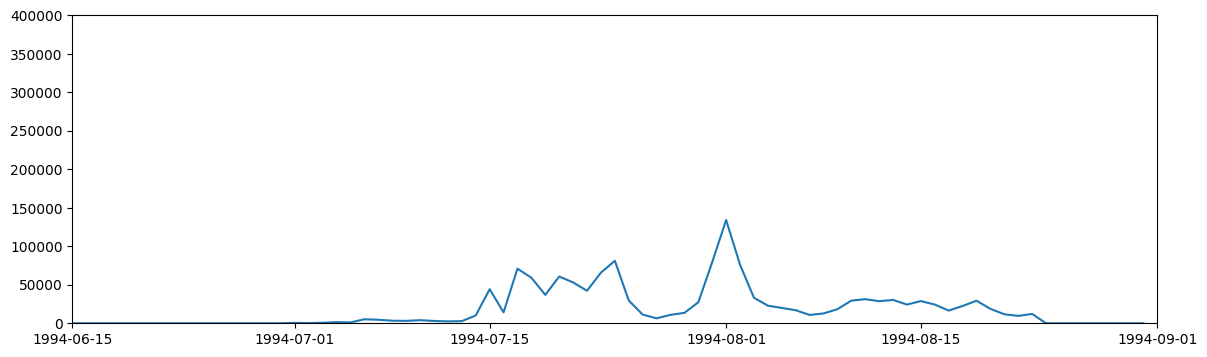

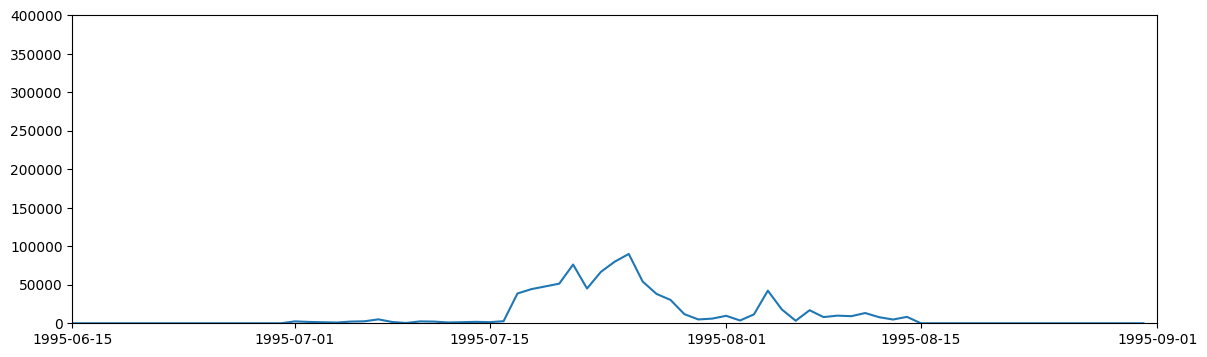

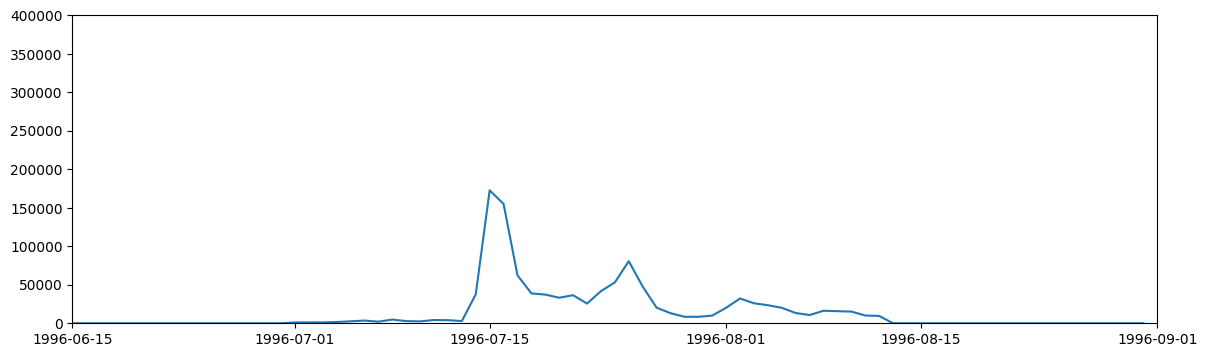

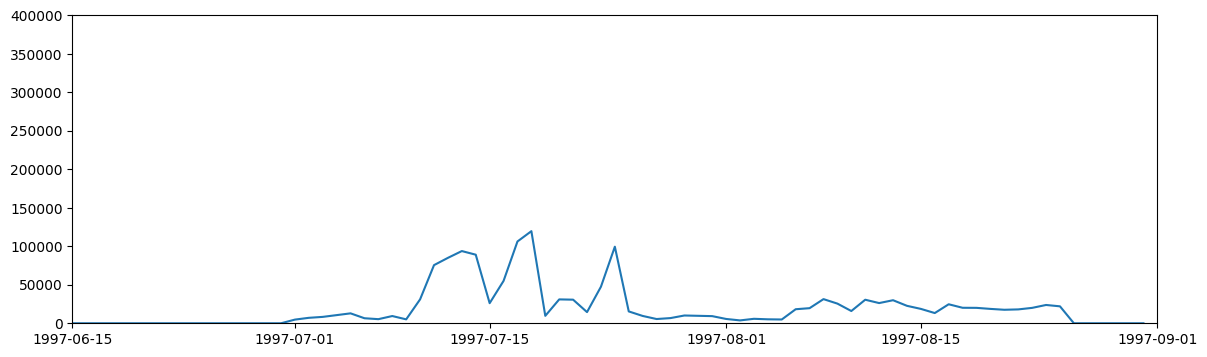

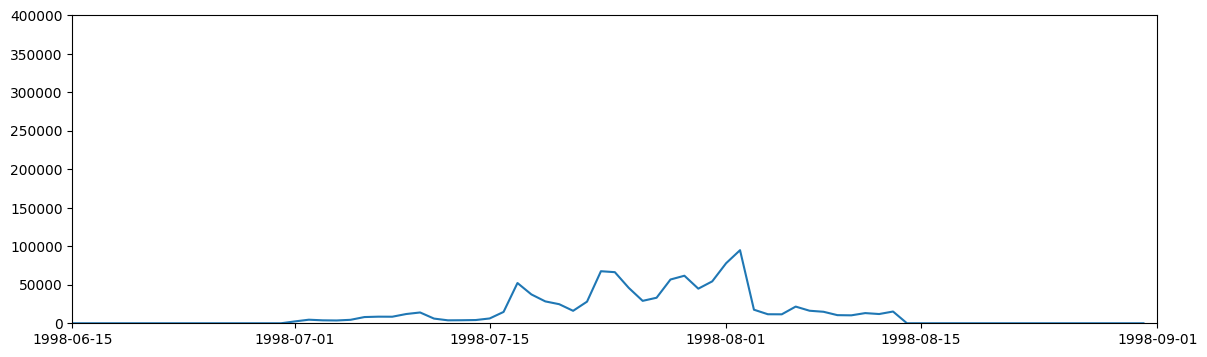

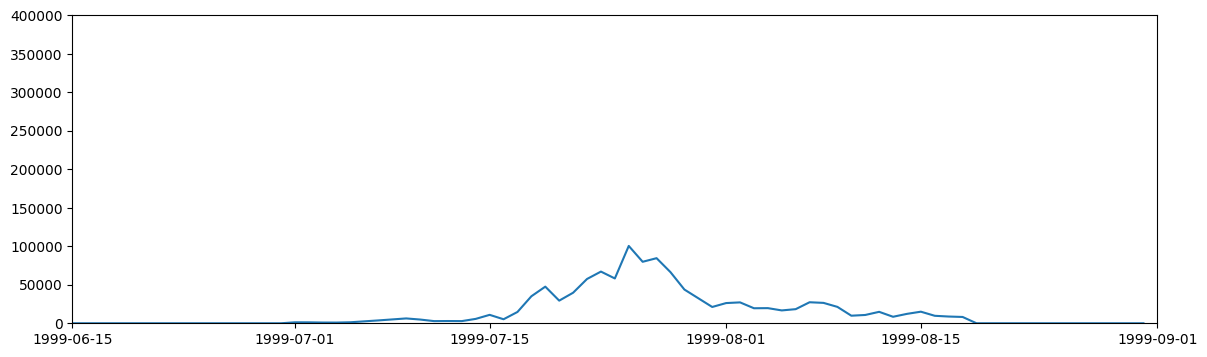

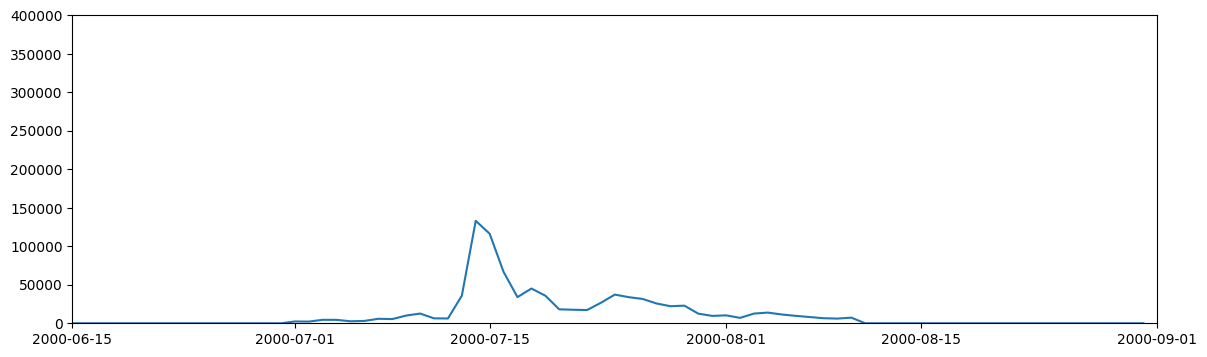

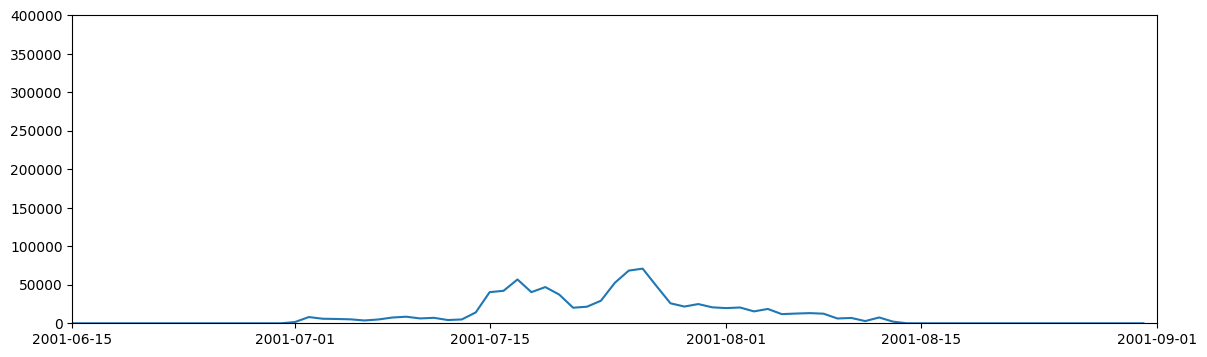

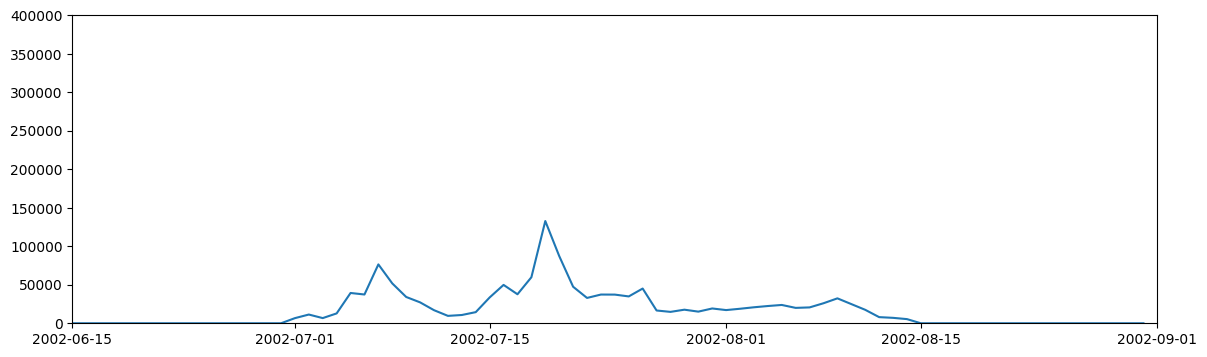

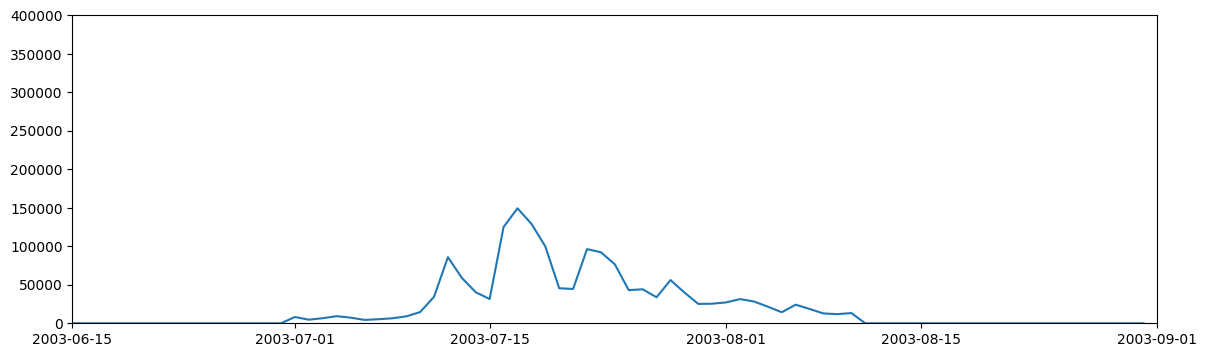

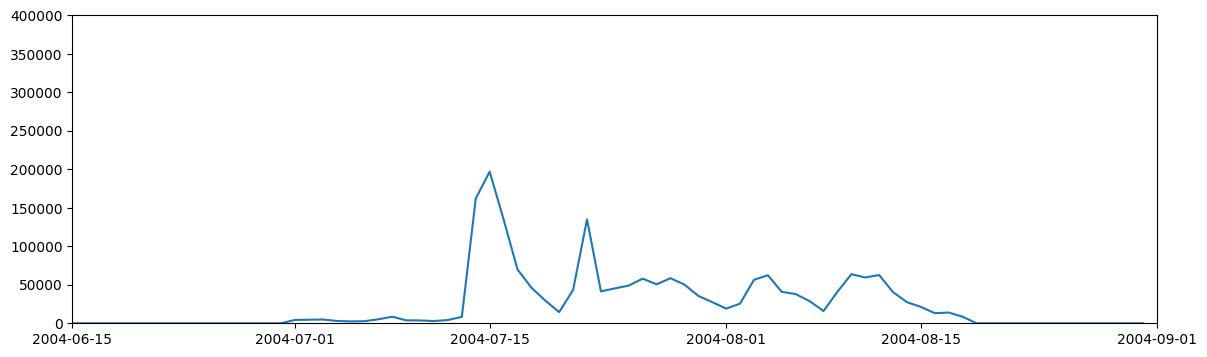

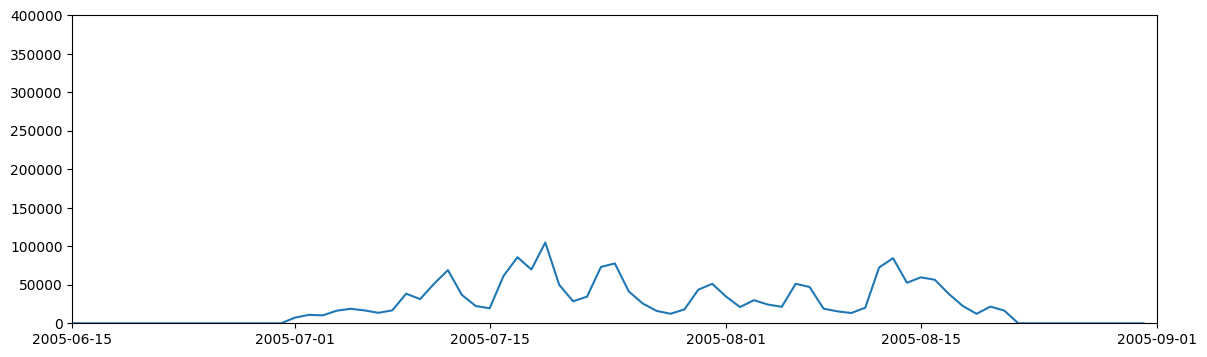

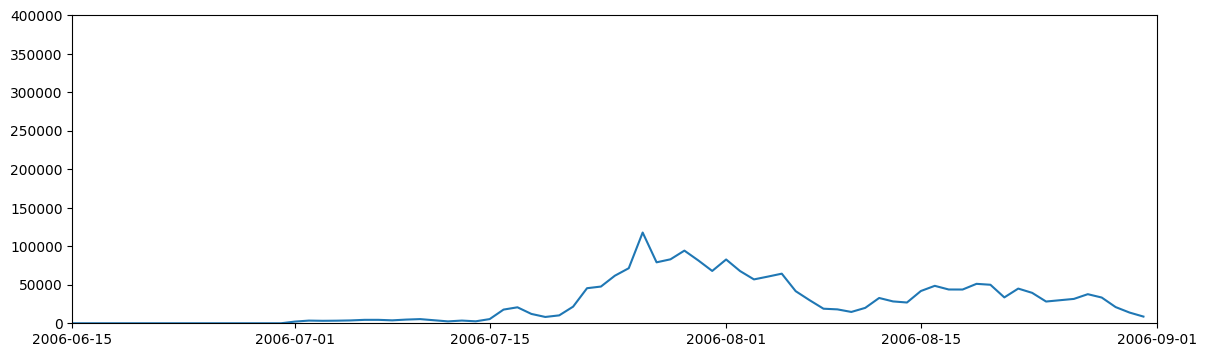

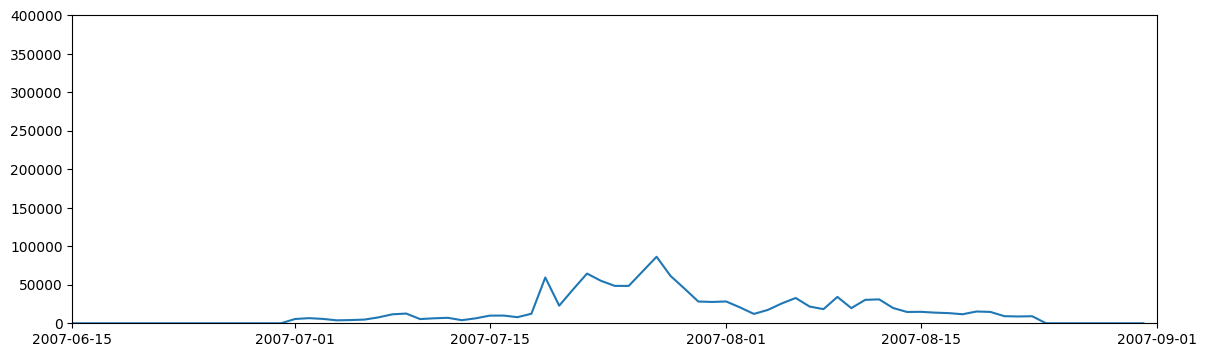

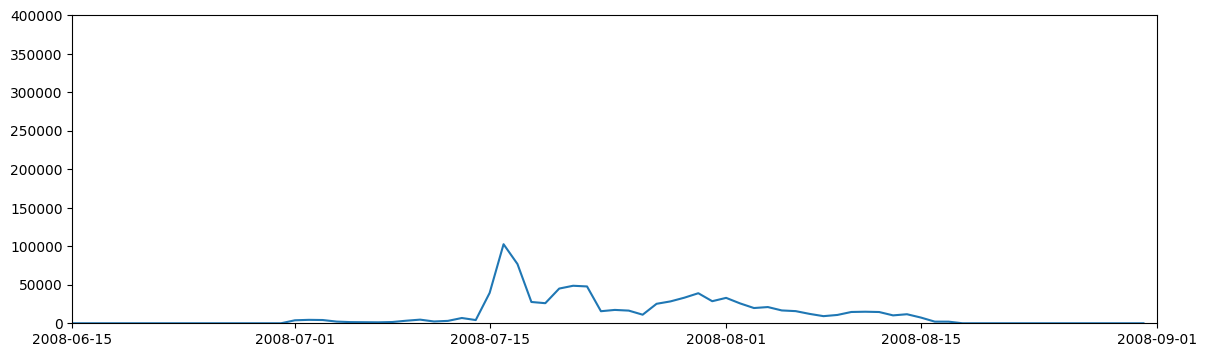

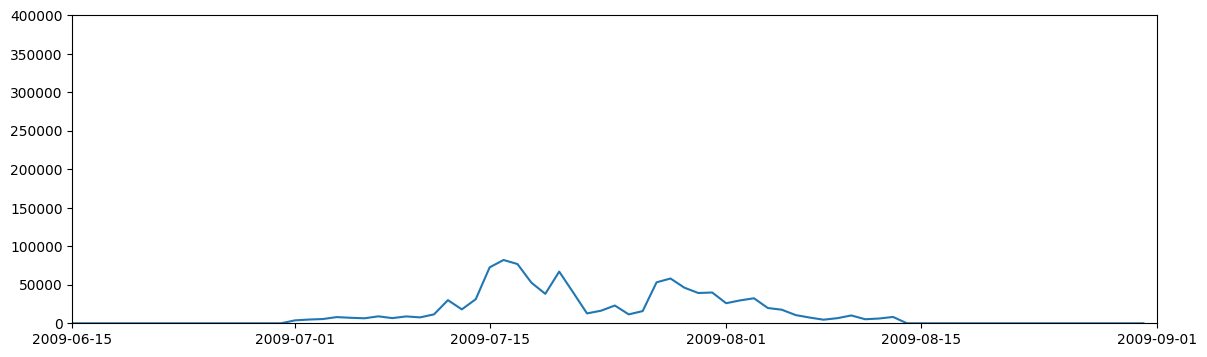

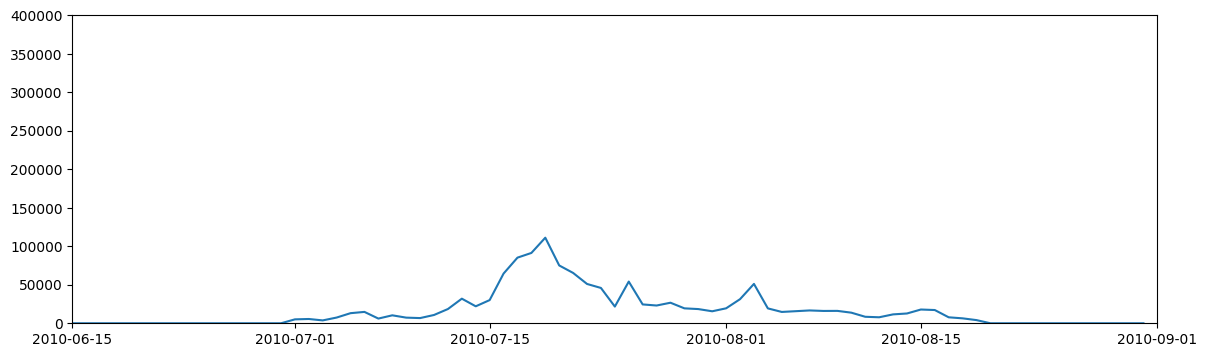

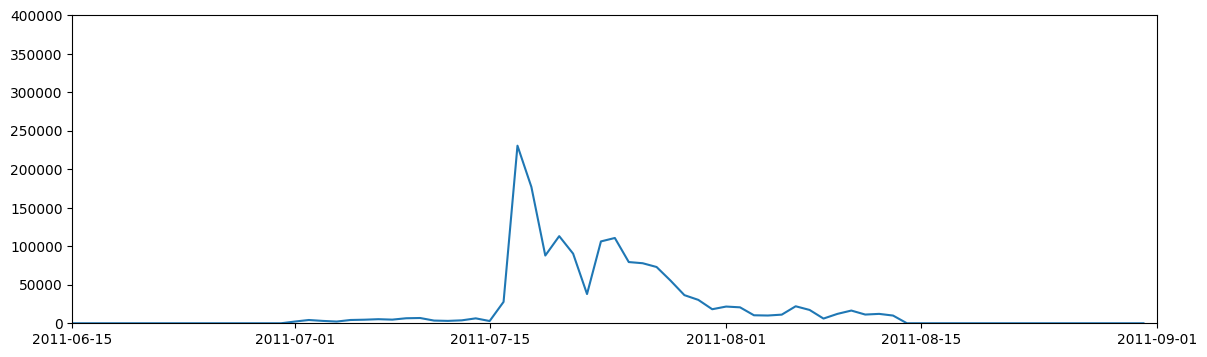

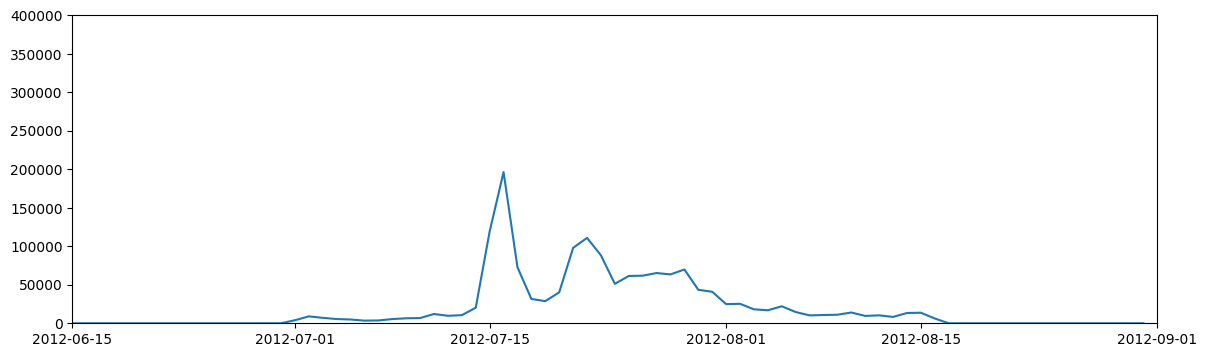

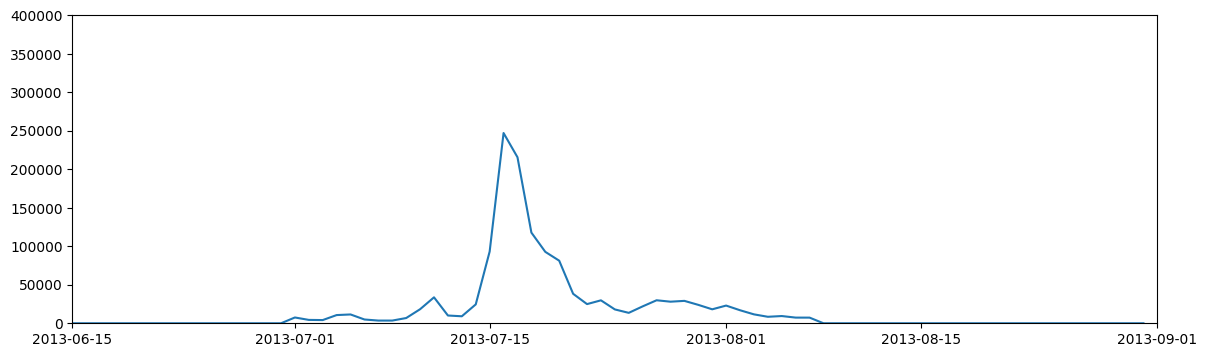

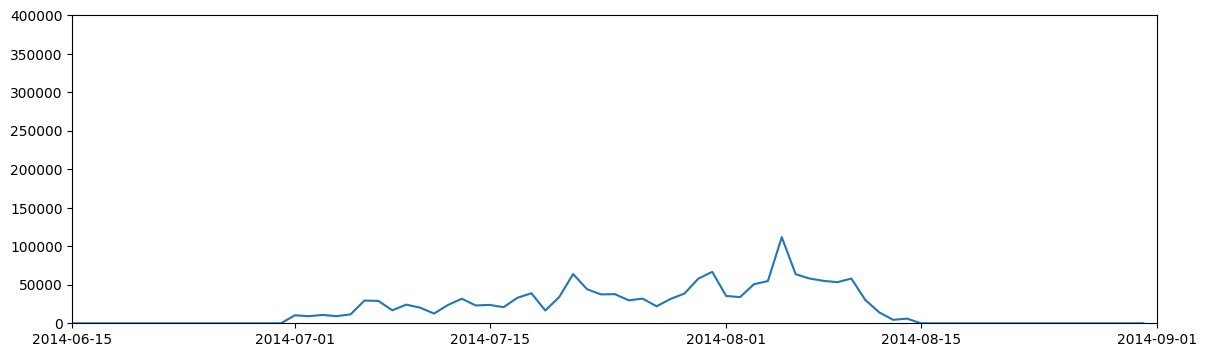

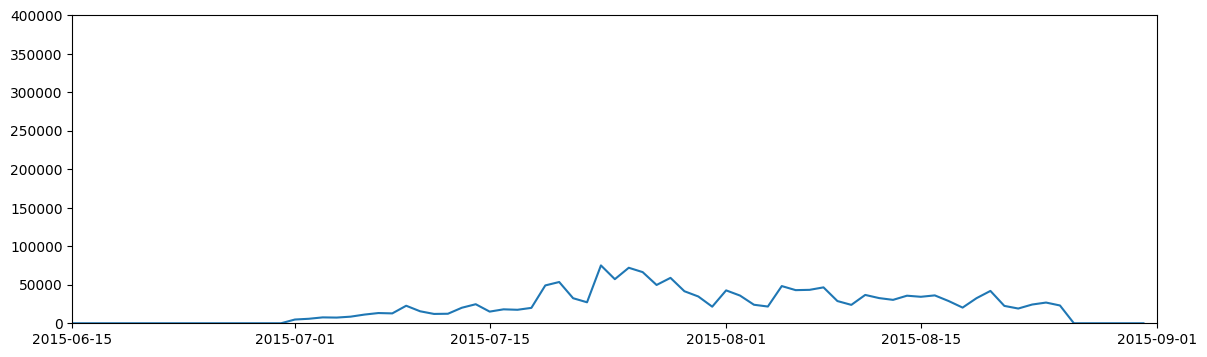

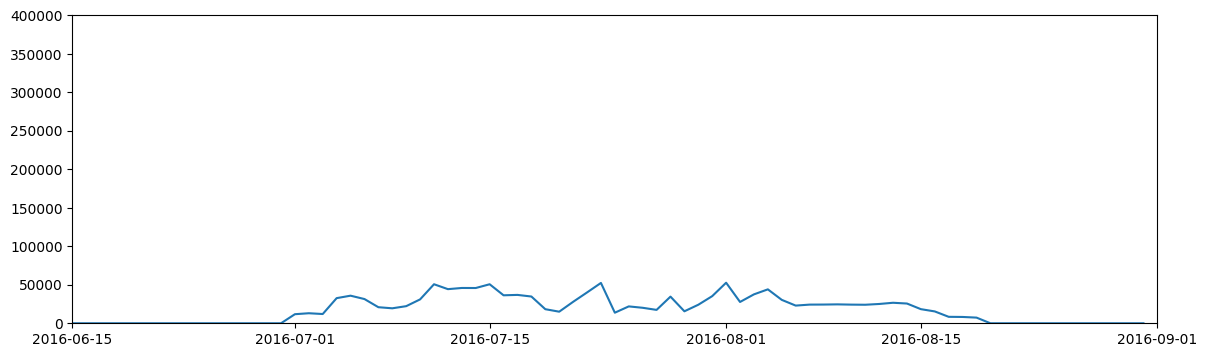

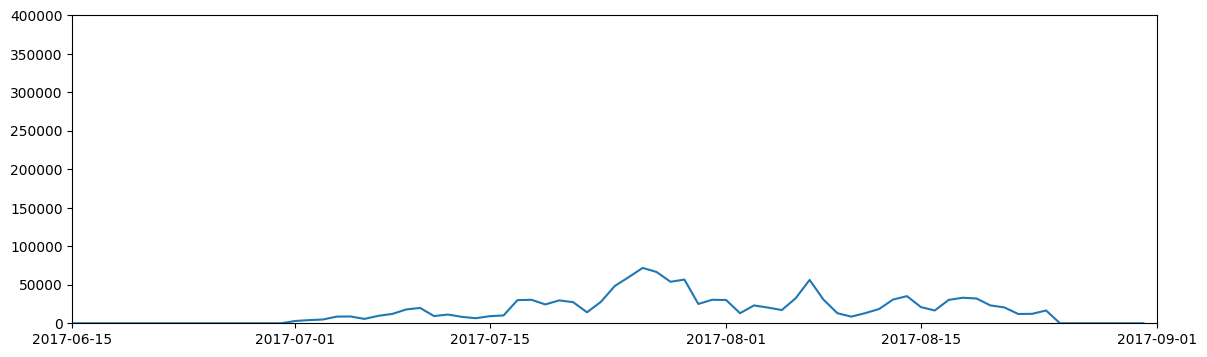

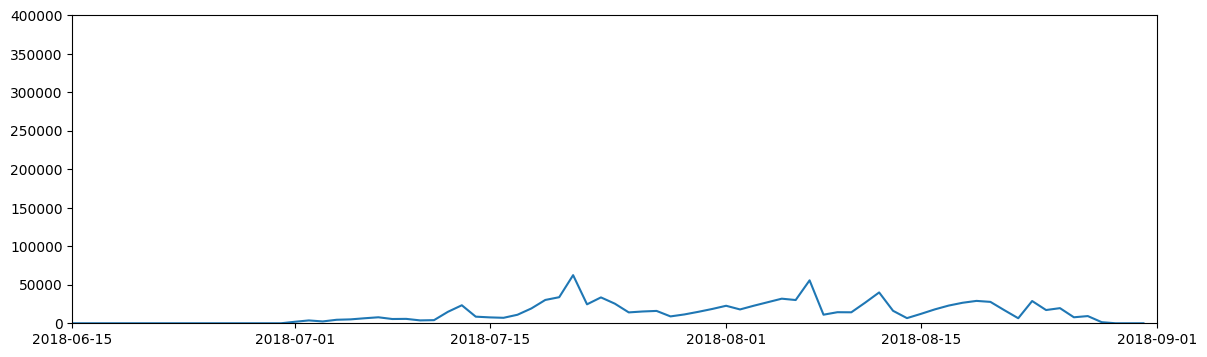

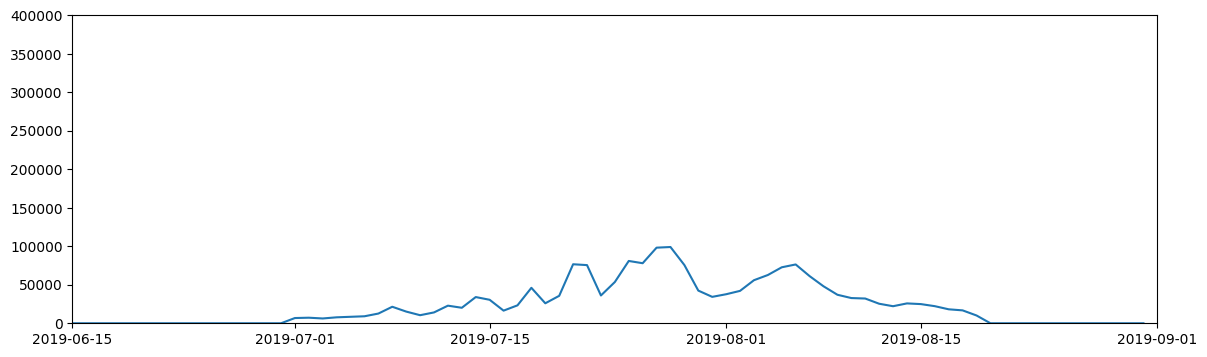

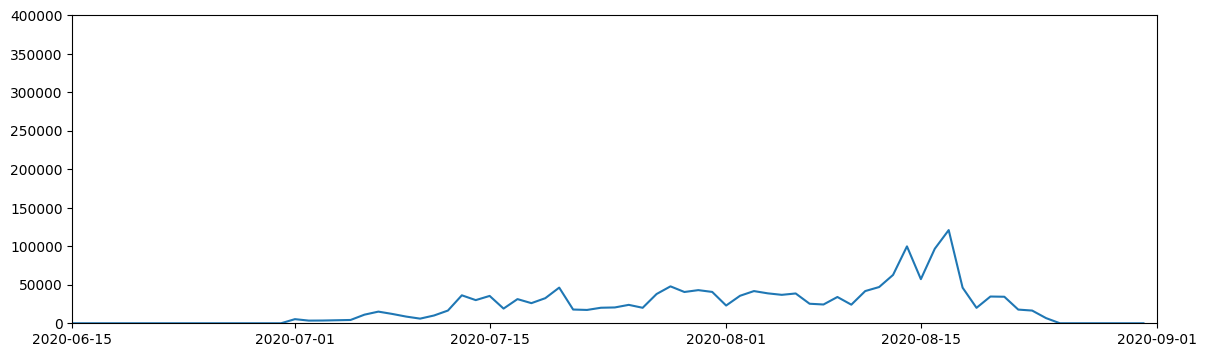

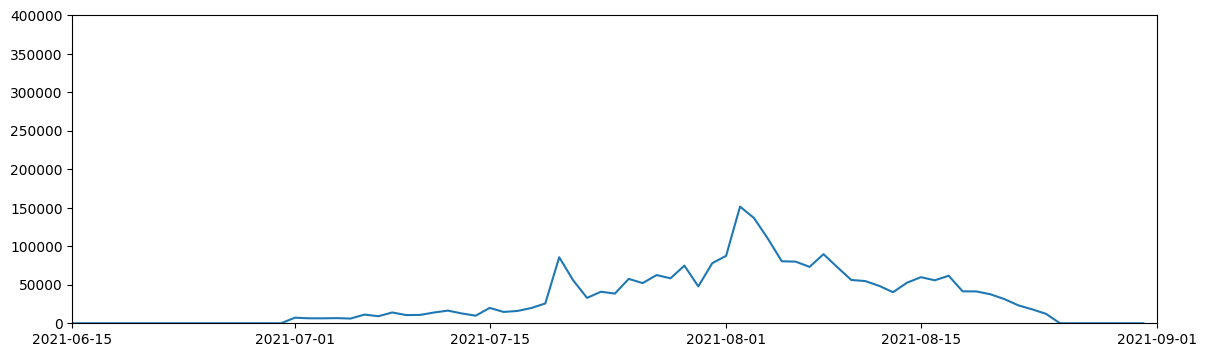

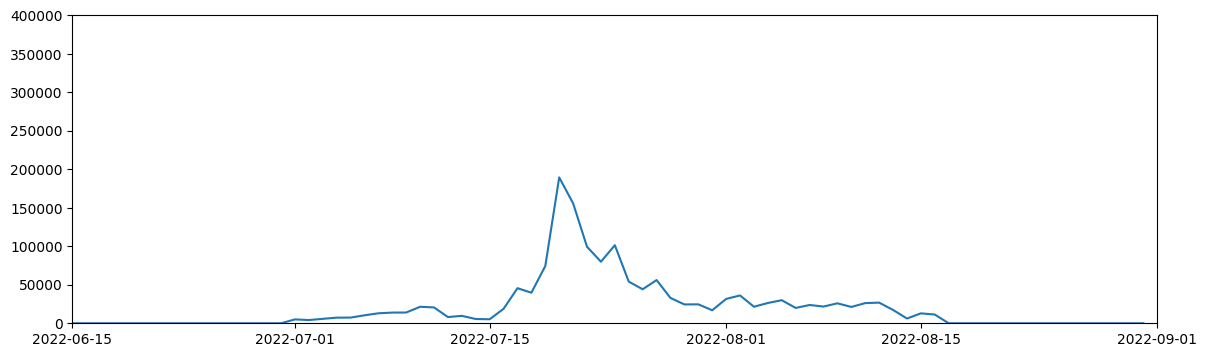

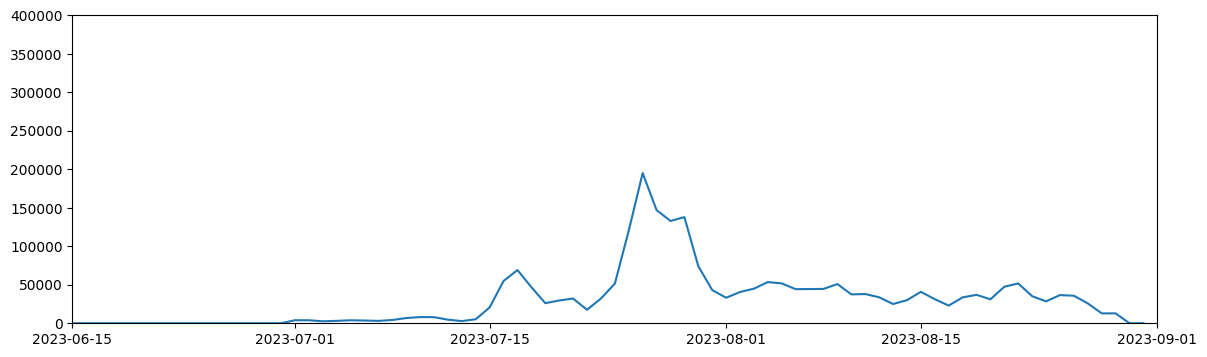

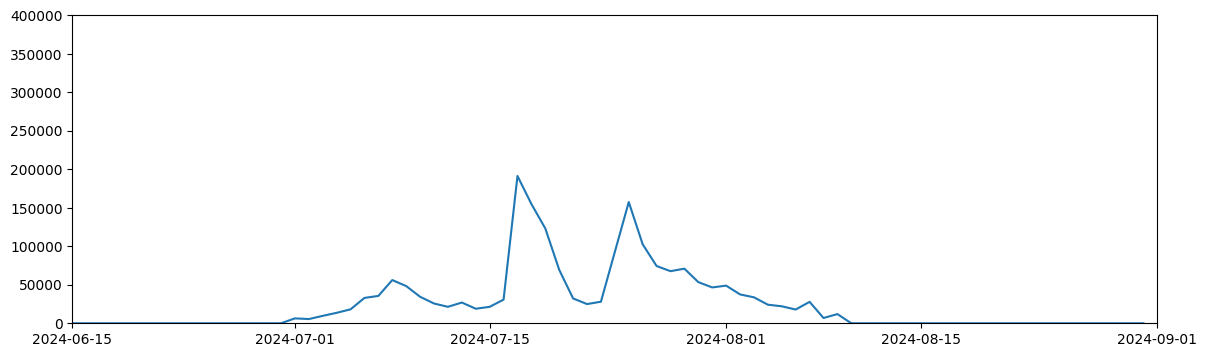

In [37]:
# View data year-by-year
for yr in range(1979, 2025):
  plt.figure(figsize=(14,4))
  plt.plot(df_historical.loc[df_historical['ds'].dt.year == yr].ds, df_historical.loc[df_historical['ds'].dt.year == yr].y)
  plt.xlim(datetime(yr, 6, 15), datetime(yr, 9, 1))
  plt.ylim(0, 400000)